## Prediction of time series with different neural networks architectures

In this notebook we will use different network architectures to predict the next steps for a time series. We compare:

- 1D causal convolutional networks
- 1D causal convolutional networks witho dilation rate
- RNNs
- LSTMs

We forecast a time series for longer times than we trained them on and compare the results of the different architectures. The goal is to capture the longterm dependencies of the time series.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras

### Simulate some data
We produce training data with two different time scales and a bit of noise. This produces 1000 curves which all follow the same pattern: a fast changing sine wave where the amplitude is modulated by a sine wave with lower frequency. To make it a bit more challenging, we add some noise at each timestep of the waves. All of the 1000 waves have the same pattern, however, the starting point is randomly shifted in time. One such example is shown the plot below. The first 128 data points are used as an input to the model (shown as a line). The model should predict the following 10 data points (shown as points). Note that the future data does not follow a smooth curve, but instead is ragged because of the random noise present in the data.

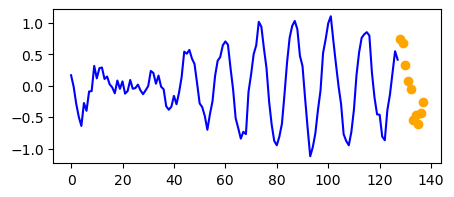

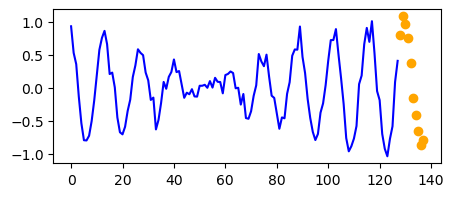

The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.


In [62]:
np.random.seed(1)  # Fixing the seed, so that data is always the same
seq_length = 128  # Sequence length used for training
look_ahead = 10  # The number of data points the model should predict


def gen_data(size=1000, noise=0.1):  # We create 1000 data-points
    s = seq_length + look_ahead
    d = np.zeros((size, s, 1))
    for i in range(size):
        start = np.random.uniform(0, 2 * np.pi)  # Random start point
        d[i, :, 0] = np.sin(start + np.linspace(0, 20 * np.pi, s)) * np.sin(
            start + np.linspace(0, np.pi, s)) + np.random.normal(0, noise, s)
    return d[:, 0:seq_length], d[:, seq_length:s]


X, Y = gen_data()
for i in range(2):
    plt.figure(num=None, figsize=(5, 2))
    plt.plot(range(0, seq_length), X[i, :, 0], 'b-')
    plt.plot(range(seq_length, seq_length + look_ahead), Y[i, :, 0], 'o', color='orange')

plt.show()
print('The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.')

### a.) 1D Convolution without dilation rate

Build network

Here we define a Neural network with 1D convolutions and "causal" padding.

Build a first model using the causal convolutions. Don't specify the sequence length (batch_input_shape=(None, None, 1)), so you can use a different sequence length in prediction later. The network should have 4, 1-dimensional convolutional layers, with a kernelsize of ks=5 and 32 feartures. Use the keras function Convolution1D for that. The network should report 10 values that the end. You can achive this with the function.

```
{python}
def slice(x, slice_length):
    return x[:,-slice_length:,:]

....
model1.add(Lambda(slice, arguments={'slice_length':look_ahead}))
```

Which you add at the end of the network.

Use the first 800 sequences for training and the last 200 for validation. As loss function we use the mean squared error (MSE). You should get a MSE of approx 0.02 to 0.03.


In [3]:
def slice(x, slice_length):
    return x[:, -slice_length:, :]

In [47]:
model_1 = keras.Sequential([
    keras.Input((None, 1)),
    keras.layers.Conv1D(filters=32, kernel_size=(5), padding="causal", activation="relu", name="conv1"),
    keras.layers.Conv1D(filters=32, kernel_size=(5), padding="causal", activation="relu", name="conv2"),
    keras.layers.Conv1D(filters=32, kernel_size=(5), padding="causal", activation="relu", name="conv3"),
    keras.layers.Conv1D(filters=32, kernel_size=(5), padding="causal", activation="relu", name="conv4"),
    keras.layers.Dense(1, name="output"),
    keras.layers.Lambda(slice, arguments={'slice_length': look_ahead})
])

model_1.compile(optimizer=keras.optimizers.Adam(), loss="mean_squared_error")

model_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv1D)              (None, None, 32)          192       
                                                                 
 conv2 (Conv1D)              (None, None, 32)          5152      
                                                                 
 conv3 (Conv1D)              (None, None, 32)          5152      
                                                                 
 conv4 (Conv1D)              (None, None, 32)          5152      
                                                                 
 output (Dense)              (None, None, 1)           33        
                                                                 
 lambda_3 (Lambda)           (None, None, 1)           0         
                                                                 
Total params: 15,681
Trainable params: 15,681
Non-trai

In [48]:
history = model_1.fit(X[:800], Y[:800], epochs=50, validation_data=(X[800:], Y[800:]))

Epoch 1/50
25/25 [==============================] - 9s 219ms/step - loss: 0.0997 - val_loss: 0.0411
Epoch 2/50
25/25 [==============================] - 1s 27ms/step - loss: 0.0369 - val_loss: 0.0306
Epoch 3/50
25/25 [==============================] - 1s 28ms/step - loss: 0.0296 - val_loss: 0.0251
Epoch 4/50
25/25 [==============================] - 1s 26ms/step - loss: 0.0253 - val_loss: 0.0224
Epoch 5/50
25/25 [==============================] - 1s 25ms/step - loss: 0.0235 - val_loss: 0.0200
Epoch 6/50
25/25 [==============================] - 1s 22ms/step - loss: 0.0216 - val_loss: 0.0195
Epoch 7/50
25/25 [==============================] - 1s 21ms/step - loss: 0.0215 - val_loss: 0.0193
Epoch 8/50
25/25 [==============================] - 1s 23ms/step - loss: 0.0210 - val_loss: 0.0192
Epoch 9/50
25/25 [==============================] - 1s 25ms/step - loss: 0.0204 - val_loss: 0.0192
Epoch 10/50
25/25 [==============================] - 1s 23ms/step - loss: 0.0200 - val_loss: 0.0196
Epoch 11

#### Make repeated predictions
Since we work with simulated data, we can produce as much new data as we like. We can also switch off the noise and check how well the model can extract the real underlying pattern in the data.

In [6]:
x_test, y_test = gen_data(size=1, noise=0.0)
print(x_test.shape)
print(y_test.shape)
model_1.predict(x_test).reshape(-1)  #Predicts 10 value

(1, 128, 1)
(1, 10, 1)
1/1 [==============================] - 1s 713ms/step


array([ 0.90010905,  0.7842908 ,  0.5774753 ,  0.23588999, -0.10233063,
       -0.4184483 , -0.66664684, -0.7749587 , -0.6630645 , -0.42765608],
      dtype=float32)

Write a function which predicts 10 values from a starting sequence of size 128. Then add these predicted values to the starting sequence and uses this sequence of length 138 as a new starting sequence. Repeat this procedure 12 times. You should get a prediction for 120 time points in the future.

In [39]:
def make_prediction(x, model):
    for _ in range(12):
        pred = model.predict(x, verbose=False).reshape(-1)
        x = np.append(x, pred)[np.newaxis, :, np.newaxis]

    return x

Text(0.5, 1.0, 'Predictions with causal 1D Convolution')

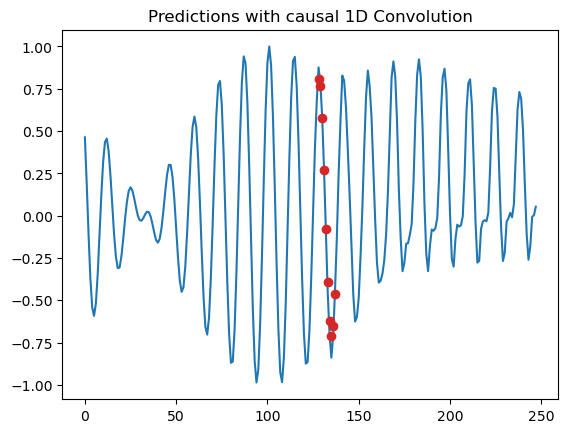

In [64]:
x, y = gen_data(size=1, noise=0.0)
plt.plot(np.squeeze(make_prediction(x, model_1)), c="tab:blue")
plt.plot(range(128, 138), np.squeeze(y), "o", c="tab:red")
plt.title("Predictions with causal 1D Convolution")

### b.) 1D Convolution with dilation rate
Here we define a Neural network with 1D convolutions and "causal" padding, this time with dilation rate, so we are able to look back longer in time (see figure below)

Build the same network as in A) but this time with dilation_rates 1,2,4,8

In [44]:
model_2 = keras.Sequential([
    keras.Input((None, 1)),
    keras.layers.Conv1D(filters=32, kernel_size=(5), dilation_rate=1, padding="causal", activation="relu",
                        name="conv1"),
    keras.layers.Conv1D(filters=32, kernel_size=(5), dilation_rate=2, padding="causal", activation="relu",
                        name="conv2"),
    keras.layers.Conv1D(filters=32, kernel_size=(5), dilation_rate=4, padding="causal", activation="relu",
                        name="conv3"),
    keras.layers.Conv1D(filters=32, kernel_size=(5), dilation_rate=8, padding="causal", activation="relu",
                        name="conv4"),
    keras.layers.Dense(1, name="output"),
    keras.layers.Lambda(slice, arguments={'slice_length': look_ahead})
])

model_2.compile(optimizer=keras.optimizers.Adam(), loss="mean_squared_error")

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv1D)              (None, None, 32)          192       
                                                                 
 conv2 (Conv1D)              (None, None, 32)          5152      
                                                                 
 conv3 (Conv1D)              (None, None, 32)          5152      
                                                                 
 conv4 (Conv1D)              (None, None, 32)          5152      
                                                                 
 output (Dense)              (None, None, 1)           33        
                                                                 
 lambda_2 (Lambda)           (None, None, 1)           0         
                                                                 
Total params: 15,681
Trainable params: 15,681
Non-trai

In [45]:
model_2.fit(X[:800], Y[:800], epochs=50, validation_data=(X[800:], Y[800:]))

Epoch 1/50
25/25 [==============================] - 9s 233ms/step - loss: 0.1049 - val_loss: 0.0196
Epoch 2/50
25/25 [==============================] - 0s 20ms/step - loss: 0.0171 - val_loss: 0.0155
Epoch 3/50
25/25 [==============================] - 1s 23ms/step - loss: 0.0135 - val_loss: 0.0124
Epoch 4/50
25/25 [==============================] - 1s 23ms/step - loss: 0.0133 - val_loss: 0.0122
Epoch 5/50
25/25 [==============================] - 1s 24ms/step - loss: 0.0127 - val_loss: 0.0130
Epoch 6/50
25/25 [==============================] - 1s 22ms/step - loss: 0.0131 - val_loss: 0.0126
Epoch 7/50
25/25 [==============================] - 1s 25ms/step - loss: 0.0125 - val_loss: 0.0119
Epoch 8/50
25/25 [==============================] - 1s 24ms/step - loss: 0.0123 - val_loss: 0.0122
Epoch 9/50
25/25 [==============================] - 1s 23ms/step - loss: 0.0124 - val_loss: 0.0121
Epoch 10/50
25/25 [==============================] - 1s 25ms/step - loss: 0.0121 - val_loss: 0.0111
Epoch 11

Text(0.5, 1.0, 'Predictions with causal 1D Convolution using Dilation')

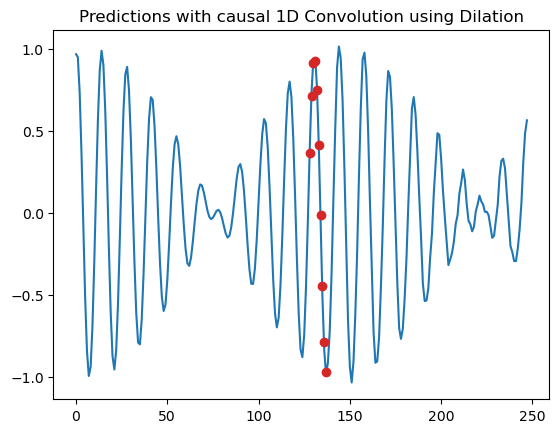

In [66]:
x, y = gen_data(size=1, noise=0.0)
plt.plot(np.squeeze(make_prediction(x, model_2)))
plt.plot(range(128, 138), np.squeeze(y), "o", c="tab:red")
plt.title("Predictions with causal 1D Convolution using Dilation")

### c.) Simple RNN
Now, use a RNN cell Keras SimpleRNN to see if we are able to learn the data generating process. Start with a hidden state size of 12. Repeat the task from A) and B). Consider to add several layers of cells and play with the state size.

In [59]:
model_3 = keras.Sequential([
    keras.Input((None, 1)),
    keras.layers.SimpleRNN(8, activation="tanh", return_sequences=True),
    keras.layers.SimpleRNN(8, activation="tanh", return_sequences=True),
    keras.layers.Dense(1, name="output"),
    keras.layers.Lambda(slice, arguments={'slice_length': look_ahead})
])

model_3.compile(optimizer=keras.optimizers.Adam(), loss="mean_squared_error")

model_3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, None, 8)           80        
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 8)           136       
                                                                 
 output (Dense)              (None, None, 1)           9         
                                                                 
 lambda_6 (Lambda)           (None, None, 1)           0         
                                                                 
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________


In [60]:
model_3.fit(X[:800], Y[:800], epochs=20, validation_data=(X[800:], Y[800:]))


Epoch 1/20
25/25 [==============================] - 17s 553ms/step - loss: 0.2616 - val_loss: 0.1408
Epoch 2/20
25/25 [==============================] - 17s 694ms/step - loss: 0.0952 - val_loss: 0.0576
Epoch 3/20
25/25 [==============================] - 17s 679ms/step - loss: 0.0494 - val_loss: 0.0432
Epoch 4/20
25/25 [==============================] - 16s 634ms/step - loss: 0.0406 - val_loss: 0.0375
Epoch 5/20
25/25 [==============================] - 13s 521ms/step - loss: 0.0367 - val_loss: 0.0346
Epoch 6/20
25/25 [==============================] - 19s 754ms/step - loss: 0.0344 - val_loss: 0.0326
Epoch 7/20
25/25 [==============================] - 19s 762ms/step - loss: 0.0327 - val_loss: 0.0312
Epoch 8/20
25/25 [==============================] - 15s 566ms/step - loss: 0.0316 - val_loss: 0.0296
Epoch 9/20
25/25 [==============================] - 19s 778ms/step - loss: 0.0304 - val_loss: 0.0285
Epoch 10/20
25/25 [==============================] - 17s 697ms/step - loss: 0.0295 - val_lo

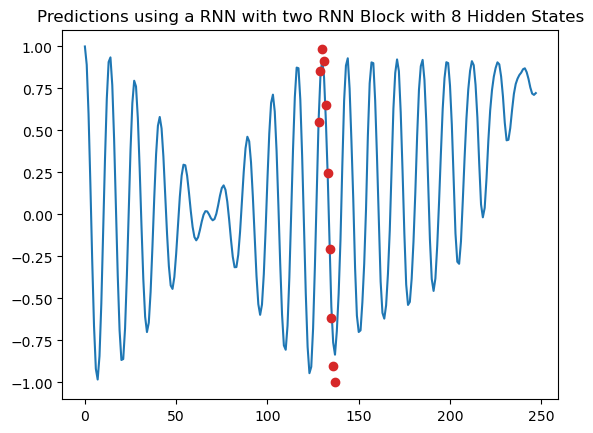

In [70]:
x, y = gen_data(size=1, noise=0.0)
plt.plot(np.squeeze(make_prediction(x, model_3)))
plt.plot(range(128, 138), np.squeeze(y), "o", c="tab:red")
plt.title("Predictions using a RNN with two RNN Blocks with 8 Hidden States");

#### 4 LSTM Cell

In [54]:
model_4 = keras.Sequential([
    keras.Input((None, 1)),
    keras.layers.LSTM(12, activation="tanh", return_sequences=True),
    keras.layers.Dense(1, name="output"),
    keras.layers.Lambda(slice, arguments={'slice_length': look_ahead})
])

model_4.compile(optimizer=keras.optimizers.Adam(), loss="mean_squared_error")

model_4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 12)          672       
                                                                 
 output (Dense)              (None, None, 1)           13        
                                                                 
 lambda_5 (Lambda)           (None, None, 1)           0         
                                                                 
Total params: 685
Trainable params: 685
Non-trainable params: 0
_________________________________________________________________


In [55]:
model_4.fit(X[:800], Y[:800], epochs=20, validation_data=(X[800:], Y[800:]))

Epoch 1/20
25/25 [==============================] - 6s 70ms/step - loss: 0.2112 - val_loss: 0.1746
Epoch 2/20
25/25 [==============================] - 0s 12ms/step - loss: 0.1467 - val_loss: 0.1138
Epoch 3/20
25/25 [==============================] - 0s 11ms/step - loss: 0.0876 - val_loss: 0.0566
Epoch 4/20
25/25 [==============================] - 0s 11ms/step - loss: 0.0407 - val_loss: 0.0283
Epoch 5/20
25/25 [==============================] - 0s 11ms/step - loss: 0.0292 - val_loss: 0.0284
Epoch 6/20
25/25 [==============================] - 0s 11ms/step - loss: 0.0289 - val_loss: 0.0287
Epoch 7/20
25/25 [==============================] - 0s 11ms/step - loss: 0.0289 - val_loss: 0.0278
Epoch 8/20
25/25 [==============================] - 0s 11ms/step - loss: 0.0285 - val_loss: 0.0275
Epoch 9/20
25/25 [==============================] - 0s 11ms/step - loss: 0.0283 - val_loss: 0.0272
Epoch 10/20
25/25 [==============================] - 0s 11ms/step - loss: 0.0281 - val_loss: 0.0268
Epoch 11/

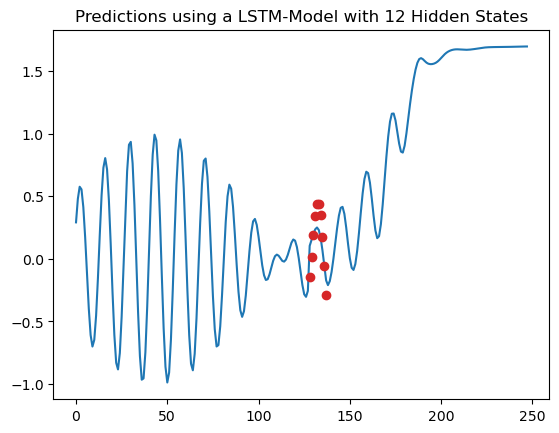

In [69]:
x, y = gen_data(size=1, noise=0.0)
plt.plot(np.squeeze(make_prediction(x, model_4)))
plt.plot(range(128, 138), np.squeeze(y), "o", c="tab:red")
plt.title("Predictions using a LSTM-Model with 12 Hidden States");